# Week 3: Fitting

In many different cases, we might have a model for how a system works, and want to fit that model to a set of observations. 

We're going to investigate the process of fitting using a classic paper that proposed a model for the [T cell receptor](https://www.ncbi.nlm.nih.gov/pubmed/11606269). Here, the authors develop a mathematical model for how binding occurs and then have observations of how much binding occurs under specific conditions. Identifying whether and how this model fits has led to a better understanding of how our immune system recognizes diseased cells, and how to design T cells that respond to diseases like cancer.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import binom
from scipy.optimize import least_squares

np.seterr(over='raise')

def StoneMod(Rtot, Kd, v, Kx, L0):
    '''
    Returns the number of mutlivalent ligand bound to a cell with Rtot
    receptors, granted each epitope of the ligand binds to the receptor
    kind in question with dissociation constant Kd and cross-links with
    other receptors with crosslinking constant Kx. All eq derived from Stone et al. (2001).
    '''
    v = np.int_(v)
    
    assert L0.shape == v.shape
    
    # Mass balance for receptor species, to identify the amount of free receptor
    diffFunAnon = lambda x: Rtot-x*(1+v*L0*(1/Kd)*(1+Kx*x)**(v-1))
    
    ## Solve Req by calling least_squares
    lsq = least_squares(diffFunAnon, np.full_like(L0, Rtot/2.0), jac_sparsity=np.eye(L0.size),
                        max_nfev=1000, xtol=1.0E-10, ftol=1.0E-10, gtol=1.0E-10,
                        bounds=(np.full_like(L0, -np.finfo(float).eps), np.full_like(L0, Rtot)))
    if lsq['cost'] > 1.0E-8:
        print(lsq)
        raise RuntimeError("Failure in solving for Req.")
        
    Req = lsq.x
    Lbound = np.zeros(Req.size)
    Rmulti = np.zeros(Req.size)
    Rbnd = np.zeros(Req.size)
    
    for ii, Reqq in enumerate(Req):
        # Calculate vieq from equation 1
        vieq = L0[ii]*Reqq*binom(v[ii], np.arange(1, v[ii] + 1))*np.power(Kx*Reqq, np.arange(v[ii]))/Kd

        # Calculate L, according to equation 7
        Lbound[ii] = np.sum(vieq)

        # Calculate Rmulti from equation 5
        Rmulti[ii] = np.dot(vieq[1:], np.arange(2, v[ii] + 1, dtype=float))

        # Calculate Rbound
        Rbnd[ii] = Rmulti[ii] + vieq[0]

    return (Lbound, Rbnd, Rmulti)

Xs = np.array([8.1E-11, 3.4E-10, 1.3E-09, 5.7E-09, 2.1E-08, 8.7E-08, 3.4E-07, 1.5E-06, 5.7E-06, 2.82E-11, 1.17E-10, 4.68E-10, 1.79E-09, 7.16E-09, 2.87E-08, 1.21E-07, 4.5E-07, 1.87E-06, 1.64E-11, 6.93E-11, 2.58E-10, 1.11E-09, 4.35E-09, 1.79E-08, 7.38E-08, 2.9E-07, 1.14E-06])
Ys = np.array([-196, -436, 761, 685, 3279, 7802, 11669, 12538, 9012, -1104, -769, 1455, 2693, 7134, 11288, 14498, 16188, 13237, 988, 1734, 4491, 9015, 13580, 17159, 18438, 18485, 17958])
Vs = np.repeat([2, 3, 4], 9)

scale = 1
Rtot = 24000
Kd = 1.7e-6
Kx = 3.15e-4 
v =  np.repeat([2, 3, 4], 9)



#### (1) We will fit the data contained within Fig. 3B. Plot this data and describe the relationship you see between Kx, Kd, and valency.

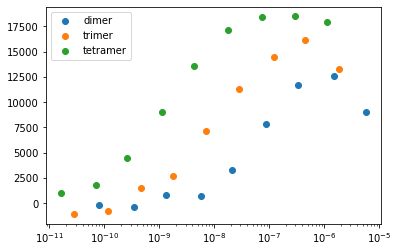

In [2]:
plt.xscale('log')

plt.scatter(Xs[0:9],Ys[0:9],label = 'dimer')
plt.scatter(Xs[9:18],Ys[9:18],label = 'trimer')
plt.scatter(Xs[18:],Ys[18:],label = 'tetramer')
plt.legend()

#### (2) First, to do so, we'll need a function that takes the model predictions, scales them to the units of the actual measurements, and finds the predictions for each condition. Define a scaling parameter and a function that takes it along with the other parameters to make predictions about the experiment.

Use the fit parameters shown in Table 1 (row 2) and overlay with the measurements to ensure your function is working. (Scale = 1 for now.)

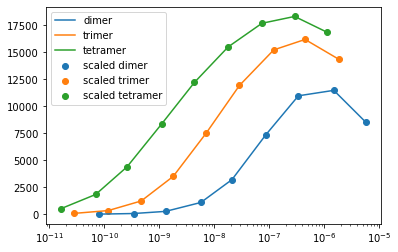

In [3]:
#from table of data at 27 hours
def CalcAndModRMulti(Rtot, Kd, v, Kx, Xs, scale):
    Rbnd = np.zeros(len(Xs))
    Rmutli = np.zeros(len(Xs))
    Lbound = np.zeros(len(Xs))
    (Lbound, Rbnd, Rmulti) = StoneMod(Rtot, Kd, v, Kx, Xs)
    Rmulti = Rmulti*scale
    
    return Rmulti

newscale = CalcAndModRMulti(Rtot, Kd, v, Kx, Xs, scale)

plt.xscale('log')
plt.plot(Xs[0:9], newscale[0:9],label = 'dimer')
plt.scatter(Xs[0:9], newscale[0:9],label = 'scaled dimer')
plt.plot(Xs[9:18], newscale[9:18],label = 'trimer')
plt.scatter(Xs[9:18], newscale[9:18],label = 'scaled trimer')
plt.plot(Xs[18:],newscale[18:],label = 'tetramer')
plt.scatter(Xs[18:], newscale[18:],label = 'scaled tetramer')
plt.legend()
    

#### (3) Now use `scipy.optimize.least_squares` to find the least squares solution.

In [4]:
def CalcAndModRMulti(Rtot, Kd, Kx, Xs, scale, v):
    Lbound = np.zeros(len(Xs))
    Rbound = np.zeros(len(Xs))
    Rmulti = np.zeros(len(Xs))
    Lbound,Rbound,Rmulti = StoneMod(Rtot, Kd, v, Kx, Xs)
    return Rmulti*scale 

i = [Kd, Kx, scale]

def Residuals(i, Xs, Ys, v, Rtot): 
    print(i)
    return (Ys - CalcAndModRMulti(Rtot, i[0], i[1], Xs, i[2],v))

def Square(Kd, Kx, scale, Xs, Ys, v, Rtot): 
    initial = [Kd, Kx, scale]
    res = least_squares(Residuals, i, args=[Xs, Ys, v, Rtot])
    return res.x

solution = Square(Kd, Kx, scale, Xs, Ys, v, Rtot)
print(solution)

[1.70e-06 3.15e-04 1.00e+00]
[1.71490116e-06 3.15000000e-04 1.00000000e+00]
[1.70000000e-06 3.15014901e-04 1.00000000e+00]
[1.70000000e-06 3.15000000e-04 1.00000001e+00]
[1.70288799e-06 3.14684772e-04 1.02819028e+00]
[1.71778915e-06 3.14684772e-04 1.02819028e+00]
[1.70288799e-06 3.14699673e-04 1.02819028e+00]
[1.70288799e-06 3.14684772e-04 1.02819030e+00]
[1.70286023e-06 3.14734018e-04 1.02814719e+00]
[1.71776139e-06 3.14734018e-04 1.02814719e+00]
[1.70286023e-06 3.14748919e-04 1.02814719e+00]
[1.70286023e-06 3.14734018e-04 1.02814721e+00]
[1.70286056e-06 3.14731351e-04 1.02815016e+00]
[1.71776172e-06 3.14731351e-04 1.02815016e+00]
[1.70286056e-06 3.14746252e-04 1.02815016e+00]
[1.70286056e-06 3.14731351e-04 1.02815018e+00]
[1.70286056e-06 3.14731351e-04 1.02815016e+00]


#### (4) Using leave-one-out crossvalidation, does this model predict the data? Plot the measured vs. predicted data.

#### (5) Using bootstrap estimation, plot the confidence interval of the model predictions along with the data points.
"Confidence interval" does not have a precise definition. For example, you could show the interval over which 50% of the bootstrap samples fall (25th to 75th quantile).

In [ ]:
# Answer

#### (6) How would you expect the cross-validation and bootstrap results to change if you had fewer data points?

Explain your answer.

I would expect my results to be less accurate with fewer data points. The bootstrap results would rely on the same data points more times to create the same number of datasets. The cross-validation results would also be less accurate because there are less datasets that could be created, reducing the number of possible folds.

#### (7) Now, we will perform a local sensitivity analysis to look at the dependence of the model results on each parameter. Vary each parameter up and down by 10-fold **while holding the others constant**, and plot the sum of squared error. Which parameter influences the fit the most? Which one the least?

#### (8) While easier to perform, a local sensitivity analysis ignores codependency between the parameters. Do you anticipate your predictions of the parameter values will be more or less specified with a global analysis?

When using global analysis, I think my parameter values should be more specified, as the other parameters could compensate for outliers in my data brought on by the varied parameter.

#### (9) Now, vary each parameter from the optimal solution, *allowing the other parameters to vary*. Was your prediction true? How might the other parameters be varying when $K_d$ increases?

Hint: The easiest way to do this is mess with the bounds of the least squares solver.

In [ ]:
# Answer

#### (10) At the same time as providing the number of multimerized receptors, the model also infers the quantities of other properties, such as the amount of ligand and receptor bound. Using the bootstrap estimates, plot the confidence in these other parameters.

In [ ]:
# Answer